In [ ]:
#

# Read Me

* Using R-metric to forecast daily max. T2M
* Dataset extended `1980-01-01`:`2010-12-31`
* Added checks for overfitting
* Learning rate now decreases hyperbollically

## Imports

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorboard
import xarray as xr


mpl.rcParams['figure.figsize'] = (8, 8)
# mpl.rcParams['axes.grid'] = False
sns.set(style='whitegrid')
!pip install netcdf4

     |████████████████████████████████| 4.3MB 2.8MB/s 
     |████████████████████████████████| 296kB 33.7MB/s 


In [ ]:
tf.__version__

'2.3.0'

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:

colspecs=[(0,10), (11,24)]
cols=['Time', 'amp']
df_NAO = pd.read_fwf('/content/drive/My Drive/PhD/data/normalized_nao_daily.txt', colspecs=colspecs, 
               names=cols, na_values='******')
df_NAO.Time = pd.to_datetime(df_NAO.Time, format="%Y  %m  %d")
df_NAO.head()

,Time,amp
0,1950-01-01,0.365
1,1950-01-02,0.096
2,1950-01-03,-0.416
3,1950-01-04,-0.616
4,1950-01-05,-0.261


In [ ]:
df_NAO=df_NAO.set_index('Time')

In [ ]:
df_NAO.loc['1950-01-01', 'amp']

0.365

In [ ]:
df_NAO.loc[df_NAO.amp.isna()] = 0.

In [ ]:
df_NAO.loc[:, 'amp'] = df_NAO.amp.astype('float')

In [ ]:
df_NAO.describe().transpose() # almost normalized, can normalize it again

,count,mean,std,min,25%,50%,75%,max
amp,25292.0,0.029471,0.81305,-3.254,-0.522,0.063,0.607,2.751


In [ ]:
R_metric=xr.open_dataset('/content/drive/My Drive/PhD/data/R_metric_Nhov_35deg_65deg_1979_2018.nc')
t2m = xr.open_dataset('/content/drive/My Drive/PhD/data/T2M_40N60N_0E20E_1979_2017.nc')
v250 = xr.open_dataset('/content/drive/My Drive/PhD/data/V250_40N60N_0E20E_1979_2018.nc')
time_sel = slice('1980-01-01','2010-12-31')


# resampling with max t2m
t2m = t2m.sel(lat=52., 
             lon=13., time=time_sel).resample({'time':'D'}).max('time') 
df = t2m.to_dataframe().drop(columns=['lat','lon'
                                      ]
                                      )
df['V'] = v250.sel(lat=52.,
                   lon=13.,
                   time=time_sel).resample({'time':'D'}).mean('time').\
                   to_dataframe().drop(columns=['lat', 'lon', 'lev'])

df['R_metric'] = R_metric.R_metric.sel(lon=13.,
                                       time=time_sel).resample({'time':'D'}).mean('time')\
                                                  .to_dataframe().\
                                                  drop(columns=['lon',
                                                                'lev']
                                                       )
                                                  
df['T2M'] = df['T2M'] - 273.15 # converting to celsius
                                                
df.head()

/usr/local/lib/python3.6/dist-packages/xarray/core/common.py:1106: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset
/usr/local/lib/python3.6/dist-packages/xarray/core/common.py:1106: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


,T2M,V,R_metric
time,,,
1980-01-01,1.85,-4.752548,9.630399
1980-01-02,0.85,-8.829318,9.707974
1980-01-03,-2.15,-26.643883,9.664611
1980-01-04,-5.15,-38.085316,10.247011
1980-01-05,-0.15,7.878142,11.317321


In [ ]:
date_time = pd.to_datetime(df.index, format='%Y-%m-%D') # converting to datetime

# maps values of a series into another series
timestamp_s = date_time.map(datetime.datetime.timestamp) 
timestamp_s.values # in seconds

# converting time into a sine and cosine signal
day = 24*60*60
year = (365.2425)*day

# day sin/cos not needed for daily data
#df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
#df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

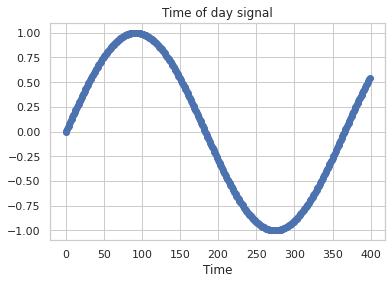

In [ ]:
plt.plot(np.array(df['Year sin'])[:400], marker='o')
#plt.plot(np.array(df['Day cos'])[:25], marker='o')
plt.xlabel('Time')
plt.title('Time of day signal')

In [ ]:
# df_NAO.amp[0:int(n*0.7)]

Time
1950-01-01    0.365
1950-01-02    0.096
1950-01-03   -0.416
1950-01-04   -0.616
1950-01-05   -0.261
              ...  
1971-09-09   -0.081
1971-09-10   -1.407
1971-09-11   -2.326
1971-09-12   -2.371
1971-09-13   -2.043
Name: amp, Length: 7926, dtype: float64

In [ ]:

# df['NAO'] = df_NAO.loc['1980-01-01':'2010-12-31', 'amp']


In [ ]:
df = df.reset_index()
df['month'] = df.time.dt.month

# winter=0...autumn=3
df.loc[:, 'season'] = 0
for mons, label in zip([[3,4,5], [6,7,8], [9,10,11]], [1,2,3]):
  df.loc[df.month.isin(mons), 'season'] = label
  

df.tail()

,time,T2M,V,R_metric,Year sin,Year cos,month,season
11318,2010-12-27,-2.15,-33.166840,8.446347,-0.084922,0.996388,12,0
11319,2010-12-28,-2.15,-30.856785,8.391964,-0.067770,0.997701,12,0
11320,2010-12-29,-8.15,-23.770456,8.584924,-0.050598,0.998719,12,0
11321,2010-12-30,-6.15,-22.605726,8.924713,-0.033410,0.999442,12,0
11322,2010-12-31,1.85,-29.862740,9.225391,-0.016213,0.999869,12,0


In [ ]:
# month=12 * day # seconds

#df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
# df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df.head()

,time,T2M,V,R_metric,Year sin,Year cos,month,season
0,1980-01-01,1.85,-4.752548,9.630399,-0.007311,0.999973,1,0
1,1980-01-02,0.85,-8.829318,9.707974,0.009891,0.999951,1,0
2,1980-01-03,-2.15,-26.643883,9.664611,0.027091,0.999633,1,0
3,1980-01-04,-5.15,-38.085316,10.247011,0.044283,0.999019,1,0
4,1980-01-05,-0.15,7.878142,11.317321,0.061461,0.998109,1,0


In [ ]:
# rounding off sine-cosine terms
#df.loc[:, 'Day sin'] = round(df['Day sin'])
#df.loc[:, 'Day cos'] = round(df['Day cos'])
df.loc[:, 'Year sin'] = round(df['Year sin'], 2)
df.loc[:, 'Year cos'] = round(df['Year cos'], 2)


df = df.drop(columns=['time'])
df.head()

,T2M,V,R_metric,Year sin,Year cos,month,season
0,1.85,-4.752548,9.630399,-0.01,1.0,1,0
1,0.85,-8.829318,9.707974,0.01,1.0,1,0
2,-2.15,-26.643883,9.664611,0.03,1.0,1,0
3,-5.15,-38.085316,10.247011,0.04,1.0,1,0
4,-0.15,7.878142,11.317321,0.06,1.0,1,0


# Split and Normalize the data

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

# Using a (70%, 20%, 10%) split for training, validation and test sets.
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

N_TRAIN = len(train_df)
num_features = df.shape[1]

num_features

7

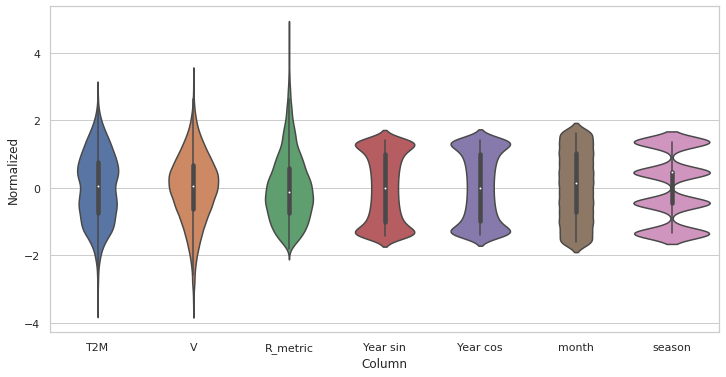

In [ ]:


train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

# Data windowing

In [ ]:
# Data Window generator class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Figure out the label column indices.
    ## Save column names as dict with an integer label
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Figure out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift  # this length is being forecasted

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width # index where label starts
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    # Note Function to split input data hasn't been added yet

  def __repr__(self):
    """"Prints objects information, useful for debugging"""
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
# example
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T2M'])
w1 # will print the __repr__

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T2M']

In [ ]:
def split_window(self, features):
  """Converts input series into a window of inputs and a window of labels"""
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='T2M', max_subplots=3):

  """Allows simple visualization of the split window
  It aligns inputs, labels and (later) predictions based on the time that the
  item refers to
  """
  inputs, labels = self.example
  plt.figure(figsize=(12, 12))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    plt.xticks(ticks=np.arange(0,101,4), labels=np.arange(0,26))
    plt.ylim((-3,3.5))

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  
  plt.xlabel('time-steps (Days)')

WindowGenerator.plot = plot

## Create tf.data.Dataset

In [ ]:
def make_dataset(self, data):
  """
  Finally this will take time series dataframe and convert it to a tensorflow
  dataset of (input_window, label_window) pairs using the 
  `preprocessing.timeseries_dataset_from_array` function.
  """
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True, # shuffles output sample
      batch_size=100) # batch size is not the number of time-steps

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset  

In [ ]:
# adding properties for accesing train, validation and test dataset from 
# Window Generator and a standard example batch for easy access and plotting 
# Example is a plot from training dataset, NOT test
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """
  Get and cache an example batch of `inputs, labels` for plotting.
  Note: this is from the training dataset
  """
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example 

In [ ]:
# Each element is an (inputs, label) pair
w1.train.element_spec
# None will determine batch size

(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

# Multi-step Baseline

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps

In [ ]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=45,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#multi_window.plot()
multi_window

Total window size: 59
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Label indices: [45 46 47 48 49 50 51 52 53 54 55 56 57 58]
Label column name(s): None

23/23 [==============================] - 0s 5ms/step - loss: 0.5245 - accuracy: 0.6223 - mse: 0.5245


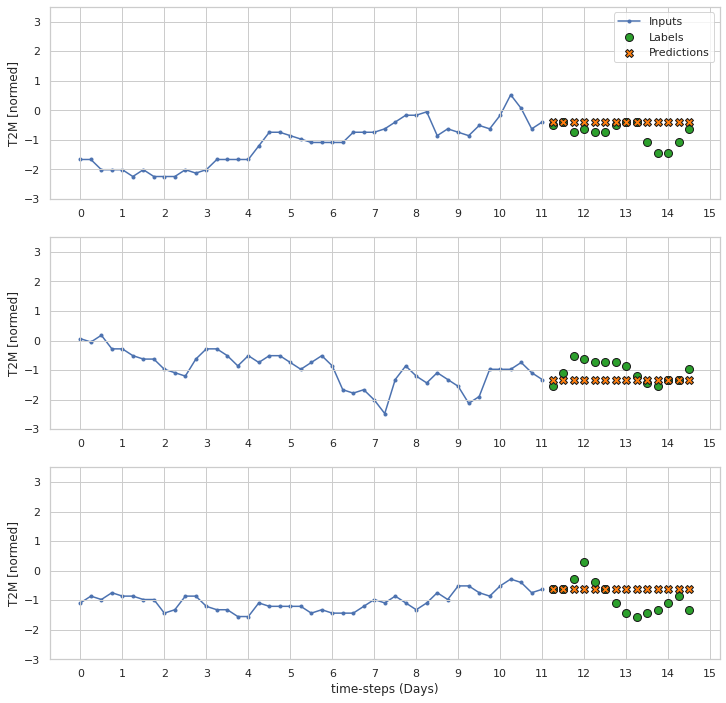

In [ ]:
# Baseline
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['accuracy', 'mse'])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


# Multi-step forecasting

In [ ]:
# Use optimizers.schedules to reduce the learning rate over time
BATCH_SIZE = 100
N_TRAIN = len(train_df)
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


def get_callbacks(name, patience):
  """Call back function , 
    name:model name
  """
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     mode='min'
                                     )
    # for using tensorboard, uncomment below
    # tf.keras.callbacks.TensorBoard(logdir/name),
  ]


def compile_and_fit(model, name, window, optimizer=None, max_epochs=200, patience=2):
  """
  Function for training procedure
  
  """
  
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=['accuracy', 'mse'])

  history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=get_callbacks(name, patience), 
                  
                      )
  return history

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
model_histories = {}
multi_lstm_model1 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False, 
                         kernel_regularizer=keras.regularizers.l2(0.001)),
    # Shape => [batch, out_steps*features]
    keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUT_STEPS*(num_features),
                          kernel_initializer=tf.initializers.zeros,
                          kernel_regularizer=keras.regularizers.l2(0.001)),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
model_histories['LSTM-1'] = compile_and_fit(multi_lstm_model1, 'LSTM-1', multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM-1'] = multi_lstm_model1.evaluate(multi_window.val)
multi_performance['LSTM-1'] = multi_lstm_model1.evaluate(multi_window.test, verbose=0)


23/23 [==============================] - 0s 12ms/step - loss: 0.3324 - accuracy: 0.6704 - mse: 0.3134


In [ ]:
multi_lstm_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 98)                3234      
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 7)             0         
Total params: 8,354
Trainable params: 8,354
Non-trainable params: 0
_________________________________________________________________


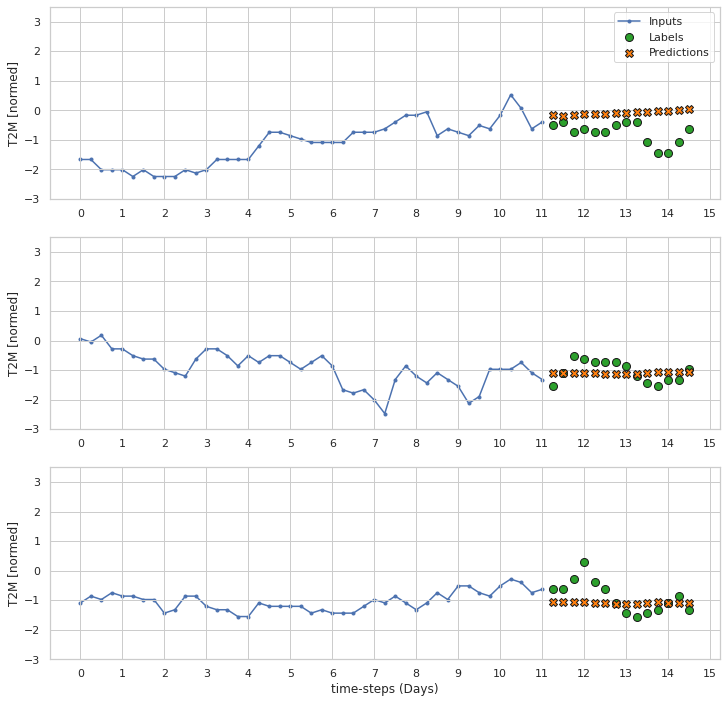

In [ ]:
multi_window.plot(multi_lstm_model1)
# plt.suptitle('LSTM-1, 6-day input');

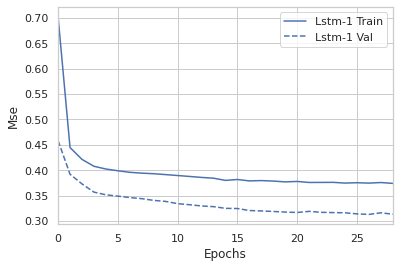

In [ ]:
plotter = tfdocs.plots.HistoryPlotter( metric='mse',
                                      )
plotter.plot(model_histories)



In [ ]:
# performance on test data
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.7829
LSTM-1  : 0.7157


In [ ]:
multi_performance

{'Baseline': [0.19851712882518768, 0.7829422354698181, 0.19851712882518768],
 'LSTM-1': [0.19971801340579987, 0.7157039642333984, 0.1846836805343628]}

## Adding another LSTM layer

In [ ]:
multi_lstm_model2 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(48, return_sequences=True),
    tf.keras.layers.LSTM(48, return_sequences=False, 
                         kernel_regularizer=keras.regularizers.l2(0.001)),
    # Shape => [batch, out_steps*features]
    keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUT_STEPS*(num_features),
                          kernel_initializer=tf.initializers.zeros,
                          kernel_regularizer=keras.regularizers.l2(0.001)),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
model_histories['LSTM-2'] = compile_and_fit(multi_lstm_model2, 'LSTM-2', multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM-2'] = multi_lstm_model2.evaluate(multi_window.val)
multi_performance['LSTM-2'] = multi_lstm_model2.evaluate(multi_window.test, verbose=0)

23/23 [==============================] - 1s 25ms/step - loss: 0.3585 - accuracy: 0.6600 - mse: 0.3444


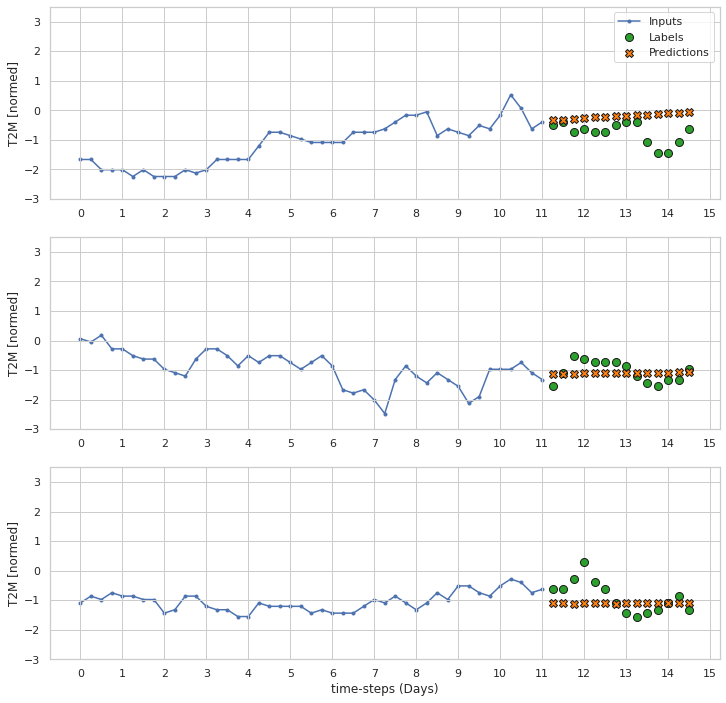

In [ ]:
multi_window.plot(multi_lstm_model2)
#plt.suptitle('LSTM-2, 6-day input');

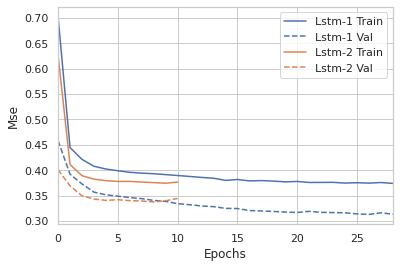

In [ ]:
plotter = tfdocs.plots.HistoryPlotter( metric='mse',
                                      )
plotter.plot(model_histories)

In [ ]:
# performance on test data
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.6431
LSTM-1  : 0.6830
LSTM-2  : 0.6760


# Models used

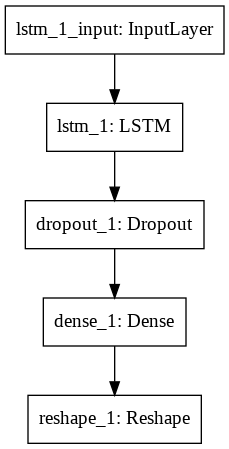

In [ ]:
tf.keras.utils.plot_model(multi_lstm_model1)

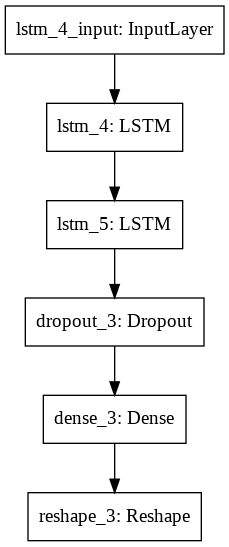

In [ ]:
tf.keras.utils.plot_model(multi_lstm_model2)

# Results

## Checking for overfitting

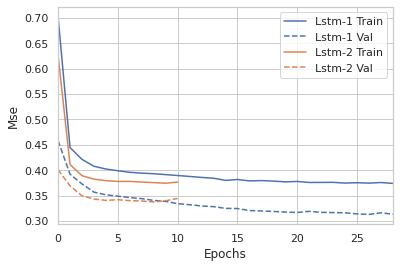

In [ ]:
plotter = tfdocs.plots.HistoryPlotter( metric='mse',
                                      )
plotter.plot(model_histories)

## Model accuracy

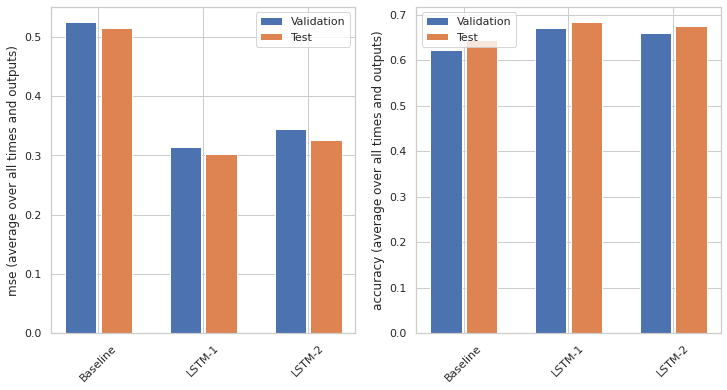

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

fig, axes = plt.subplots(1,2, figsize=[12,6])

for ax, metric_name in zip(axes, ['mse', 'accuracy']):

  metric_index = multi_lstm_model1.metrics_names.index(metric_name)
  val_mae = [v[metric_index] for v in multi_val_performance.values()]
  test_mae = [v[metric_index] for v in multi_performance.values()]

  ax.bar(x - 0.17, val_mae, width, label='Validation')
  ax.bar(x + 0.17, test_mae, width, label='Test')
  ax.set_xticks(ticks=x,) 
  ax.set_xticklabels(labels=multi_performance.keys(),
            rotation=45)
  ax.set_ylabel(f'{metric_name} (average over all times and outputs)')
  ax.legend()

In [ ]:
tf.keras.backend.clear_session()


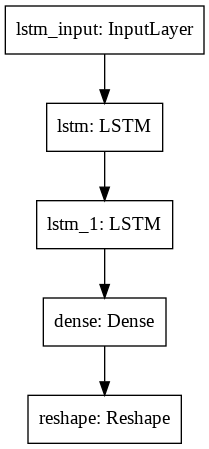

In [ ]:
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir logs

# Steps Ahead


*   Use ocean fingerprint, SSTs over Atlantic and Pacific?
*   Increase input window for the model to figure out the function better
* Re-design problem, e.g; blocking classification or NAO forecasting?